## Load Libraries and Setup

In [9]:
%matplotlib inline
import pysal as ps
import numpy as np
import pandas as pd
import geopandas as gp
import random
import shapely
import copy
import pixiedust
import acs_regionalization as ACS
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20,20  #set the default map size
#rcParams['patch.linewidth'] = 0.5  #set default polygon line width

## Spatial Data

[]

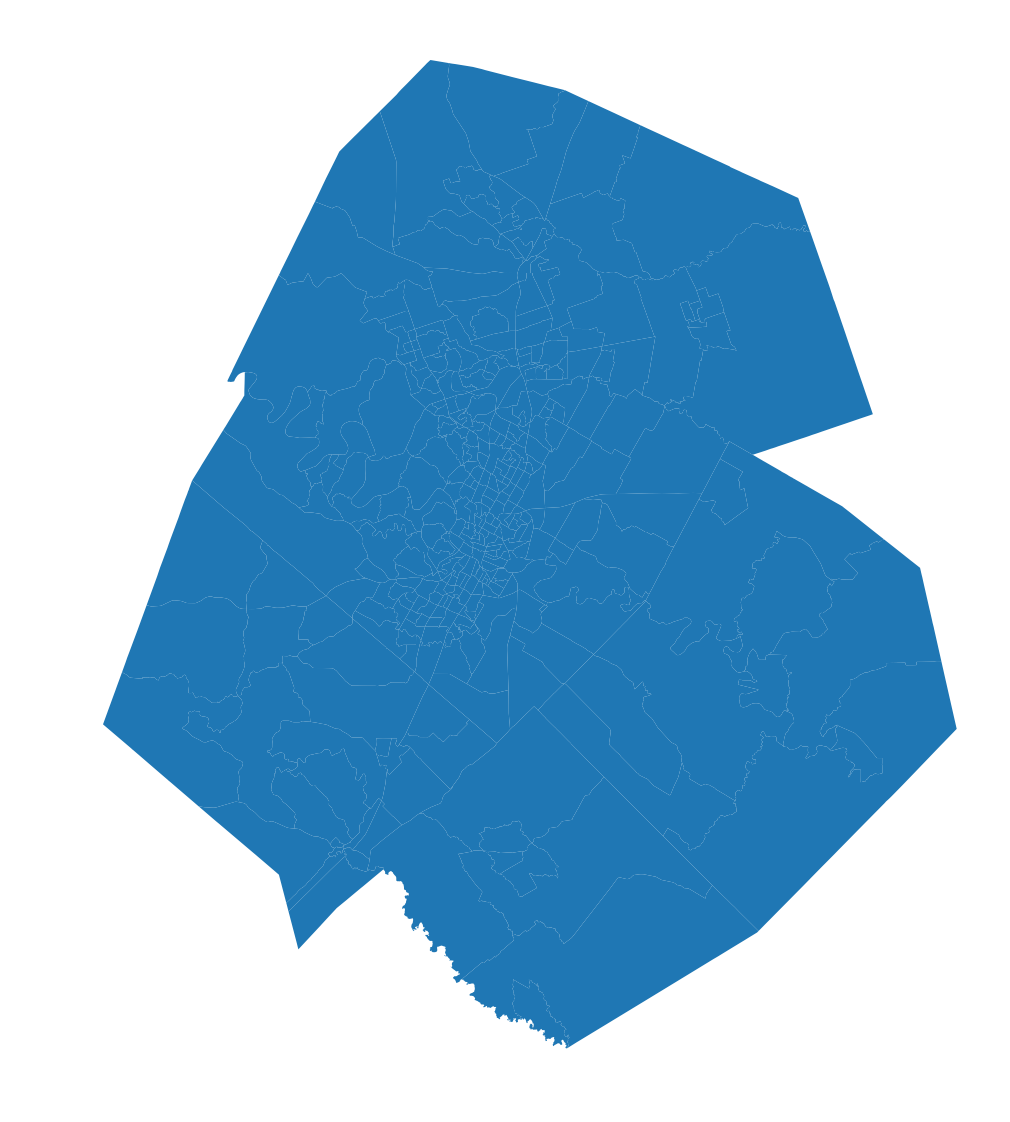

In [10]:
# read in the Austin shapefile and plot it   
shp_map = gp.read_file('example_data/12420.shp')
shp_map['constant'] = 1
p = shp_map.plot()
p.axis('off')
p.plot()

In [11]:
# read spatial data into python and run some diagnostics
w = ps.rook_from_shapefile('example_data/12420.shp', idVariable='GEOID10')
print(w.n)  # number of census tracts

350


Text(0,0.5,'number of tracts')

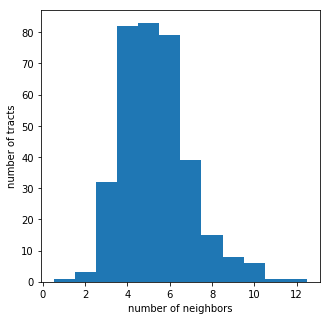

In [12]:
# summary of the connectivity structure of the Austin census tracts
w_hist_data = np.array(w.histogram)
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(w_hist_data[:,0], w_hist_data[:,1], align='center', width=1)
ax.set_xlabel('number of neighbors')
ax.set_ylabel('number of tracts')
# shows, for example, that 15 tracts have 8 neighbors

We recommend excluding census tracts that do not contain households.  These tend to be large parks, bodies of water, employment centers and institutional living situations. The algorithm will not crash if they are included, but they tend to contain missing and atypical demographic data, and therefore may get grouped arbitrarily with the more typical tracts that surround them. Austin has three census tracts with zero households: two include the airport and the third is the 95 acre [Austin State Supported Living Center](https://www.dads.state.tx.us/services/SSLC/austin.html).

In [13]:
# read in list of census tracts to exclude
exclude = open('example_data/all_exclude_12420.csv')
exclude = exclude.readline()
exclude = exclude.replace('g','')
exclude = exclude.split(',')
print(exclude)

['48453001606', '48453002319', '48453980000']


## Attribute Data

ACS data can be download directly from the USCB's [American Factfinder](http://factfinder2.census.gov) website or from places like [NHGIS](https://www.nhgis.org) or [Social Explorer](http://www.socialexplorer.com).  The USCB and NHGIS provide a margin or error (MOE) with each estimate, while Social Explorer converts these into standard errors.  See the appendix of the USCB's [ACS documentation](http://www.census.gov/acs/www/Downloads/handbooks/ACSResearch.pdf) for the conversion between MOE and standard error.  The data used below comes from Social Explorer.

In [14]:
# read in the ACS estimates and standard errors
population = pd.read_csv('example_data/all_count_est_12420.csv', index_col=0)

est_prop = pd.read_csv('example_data/transportation_prop_est_12420.csv', index_col=0)
std_prop = pd.read_csv('example_data/transportation_prop_stdErr_12420.csv', index_col=0)
moe_prop = std_prop * 1.65  # Social Explorer data is converted using 1.65 instead of the more common 1.645
prop_names = open('example_data/transportation_prop.csv')
prop_names = prop_names.readline().split(',')

est_ratio = pd.read_csv('example_data/transportation_ratio_est_12420.csv', index_col=0)
std_ratio = pd.read_csv('example_data/transportation_ratio_stdErr_12420.csv', index_col=0)
moe_ratio = std_ratio * 1.65  # Social Explorer data is converted using 1.65 instead of the more common 1.645
ratio_names = open('example_data/transportation_ratio.csv')
ratio_names = ratio_names.readline().split(',')

The regionalization algorithm uses the coefficient of variation as the uncertainty metric. The coefficient of variation (CV) is the standard error of the estimate divided by the estimate itself.  The CV therefore gives a standardized measure of uncertainty that can be interpreted as the share of the estimate that the error represents---higher CV implies greater uncertainty.

While the CV is easy to compute on variables measured in levels (e.g. the count of Hispanic residents), it is more complicated for "derived" variables. Derived variables include proportions, i.e. when the numerator is a subset of the denominator (e.g. share of the total population that is Hispanic), and ratios, i.e. when the numerator and denominator do not overlap (e.g. average household income, which is computed as aggregate household income divided by total households). Each of these three cases require a different equation, and therefore the raw data needs to be split by case before passing it to the algorithm.  See Appendix 3 of the USCB's [ACS documentation](http://www.census.gov/acs/www/Downloads/handbooks/ACSResearch.pdf) for all the equations.

Since the goal of the algorithm is to combine geographies together, these ratio and proportion data must be split into numerator and denominator.  For example, the only way to accurately compute the average household income on a combination of two geographies is to sum the two numerators, sum the two denominators, and then divide the two sums.  

In [15]:
# ratio and proportion data is organized as numerator-denominator pairs
print(ratio_names)
print(est_ratio.columns)  # names of the numerators and denominators
print('\nthe numerator of %s is %s, and the denominator is %s'%(ratio_names[1], est_ratio.columns[2], est_ratio.columns[3]))
print('the numerator of %s is %s, and the denominator is %s'%(prop_names[0], est_prop.columns[0], est_prop.columns[1]))

['vehicles_per_person', 'avg_commute_time']
Index(['ACS11_5yr_B25046001', 'ACS11_5yr_B01003001', 'ACS11_5yr_B08013001',
       'ACS11_5yr_B08134001'],
      dtype='object')

the numerator of avg_commute_time is ACS11_5yr_B08013001, and the denominator is ACS11_5yr_B08134001
the numerator of pct_drove_alone is ACS11_5yr_B08101009, and the denominator is ACS11_5yr_B08101001


## Model Parameters

__Uncertainty__: The most important parameter is the uncertainty threshold, which is measured by the coefficient of variation (CV). A [National Research Council report](http://www.nap.edu/catalog/11901.html) advises keeping the CV below 0.12, but also states "what constitutes an acceptable level of precision for a survey estimate depends on the uses to be made of the estimate" (p.67).  This is set using the `target_th_all` parameter. 

__Data standardization__: For heterogeneous datasets, like those typically drawn from the ACS, we recommend transforming the data using z-scores to get all the attributes on the same scale, and then running principle components analysis (PCA) on these standardized variables to remove any potential correlation between the attributes. The algorithm will do this automatically unless the `zscore` and `pca` parameters are set to `False`. Note that these transformed variables are only used for determining the heterogeneity of the region, feasibility (i.e. the uncertainty threshold) uses the raw data.

__Compactness__: If a shapefile is passed to the `compactness` parameter of the algorithm, then a compactness measure will be returned for each of the regions. The [isoperimetric quotient](http://en.wikipedia.org/wiki/Isoperimetric_inequality) is used to compute compactness.

__Small values__: Very small proportions tend to result in unstable and large CVs. These high CVs in turn force these census tracts to combine with an unnecessarily large number of other tracts to accommodate these small estimate values.  For example, rural areas generally have limited access to transit, resulting low values for transit usage and thus artificially high CVs. We recommend setting the `cv_exclude_prop` parameter to 0.05, which will ignore the CV threshold for proportion variables below 5%.  See the [National Research Council report](http://www.nap.edu/catalog/11901.html) (p.67,72) for more on this.  

## Running the Algorithm

Note: The code may return some "FutureWarnings", these can be ignored.

In [17]:
%%pixie_debugger
# this may take up to four minutes to run depending on hardware speed
shp = ps.open('example_data/12420.shp')
random.seed(789)  # to ensure we get the same solution each time
np.random.seed(789)  # to ensure we get the same solution each time
results = ACS.ACS_Regions(w=w, \
                          target_est_prop=est_prop.values, \
                          target_moe_prop=moe_prop.values, \
                          target_est_ratio=est_ratio.values, \
                          target_moe_ratio=moe_ratio.values, \
                          count_est=population.values, \
                          target_th_all=0.05, \
                          exclude=exclude, \
                          compactness=shp, \
                          cv_exclude_prop=0.05)
print('regionalization finished')


In [23]:
# some basic diagnostics on the solution
print 'number of regions:', len(results.regions)
print 'total time (seconds):', results.time['total']

SyntaxError: invalid syntax (<ipython-input-23-93c04644c761>, line 2)

In [10]:
# We'll make a few side-by-side plots. This code wraps the setup into a function.
def two_plot_setup():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40,40))
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    axes[0].axis('off')
    axes[1].axis('off')
    return fig, axes

Plot the solution.  On the left are the tracts colored by region, on the right are the regions.

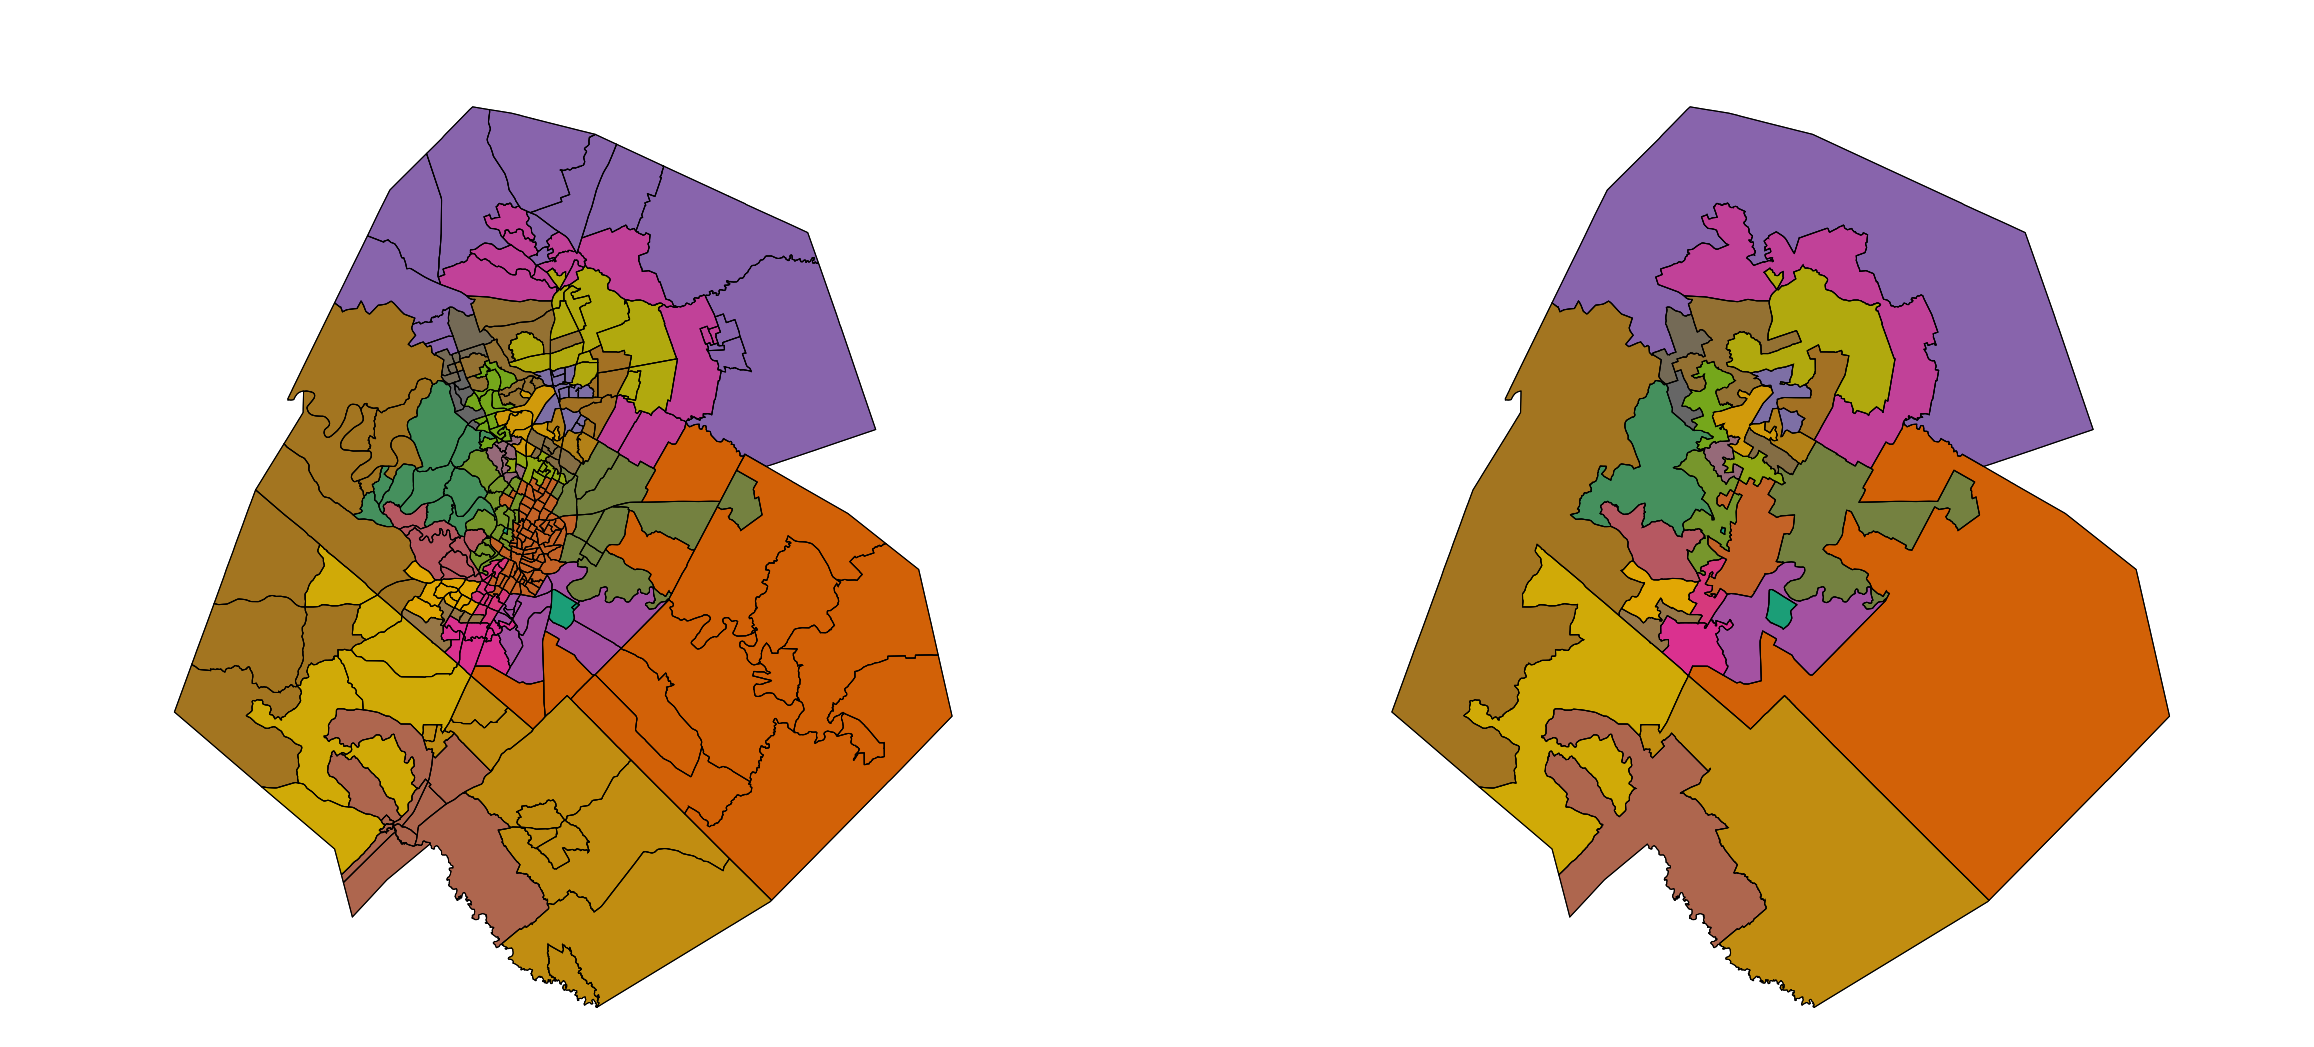

In [11]:
fig, axes = two_plot_setup()

# color tracts based on region ID
rids = copy.copy(results.region_ids)
shp_map['rids'] = rids
shp_map.plot('rids', categorical=True, alpha=1, colormap='Dark2', axes=axes[0])

# disolve the tracts into regions
region_groups = shp_map.groupby('rids')
region_map = gp.GeoDataFrame(index=region_groups.indices.keys())
region_map['rids'] = region_groups.indices.keys()
region_map['geometry'] = region_groups.geometry.apply(shapely.ops.unary_union)
region_map.plot('rids', categorical=True, alpha=1, colormap='Dark2', axes=axes[1])

## Average Commute Time

We now analyze the "before and after" situation for one of the four variables in terms of the estimates and the uncertainty.

In [12]:
# pull the data to plot from the algorithm output
print prop_names, ratio_names  # actual attribute names
print results.ests_area.columns.values  # generic attribute names generated by algorithm
ests_area = results.ests_area.ratio_var1
ests_region = results.ests_region.ratio_var1
cvs_area = results.cvs_area.ratio_var1
cvs_region = results.cvs_region.ratio_var1
#%R -i ests_area,ests_region,cvs_area,cvs_region

['pct_drove_alone', 'pct_transit'] ['vehicles_per_person', 'avg_commute_time']
['prop_var0' 'prop_var1' 'ratio_var0' 'ratio_var1']


In [13]:
# Function to provide finer grained control for the legend on geopandas plots. Based on:
# http://nbviewer.ipython.org/gist/jorisvandenbossche/d4e6efedfa1e4e91ab65
def add_legend(labels, alpha, colormap, data, plot, loc):
    labs = copy.copy(labels)
    labs.append(np.nan)
    valuemap = dict([(k, v) for (v, k) in enumerate(labs)])
    values = [valuemap[k] for k in data]
    cmap = gp.plotting.norm_cmap(values, colormap, plt.Normalize, plt.cm)
    patches = []
    for value, cat in enumerate(labs):
        patches.append(plt.Line2D([0], [0], linestyle="none",
                       marker="o", alpha=alpha,
                       markersize=20, markerfacecolor=cmap.to_rgba(value)))
    plot.legend(patches, labels, numpoints=1, loc=loc, prop={'size':30})

In the following cell we plot the initial average commute time data for all the census tracts, and then plot the same attribute for the regions.  Note that the map of regions maintains the same general spatial pattern as that in the tract data.  In other words, the algorithm has not "broken the map."  

CV counts for census tracts
13-21    79
21-23    58
23-25    44
25-27    54
27-30    51
30-46    61
dtype: int64
CV counts for regions
13-21    3
21-23    5
23-25    4
25-27    7
27-30    5
30-46    5
dtype: int64


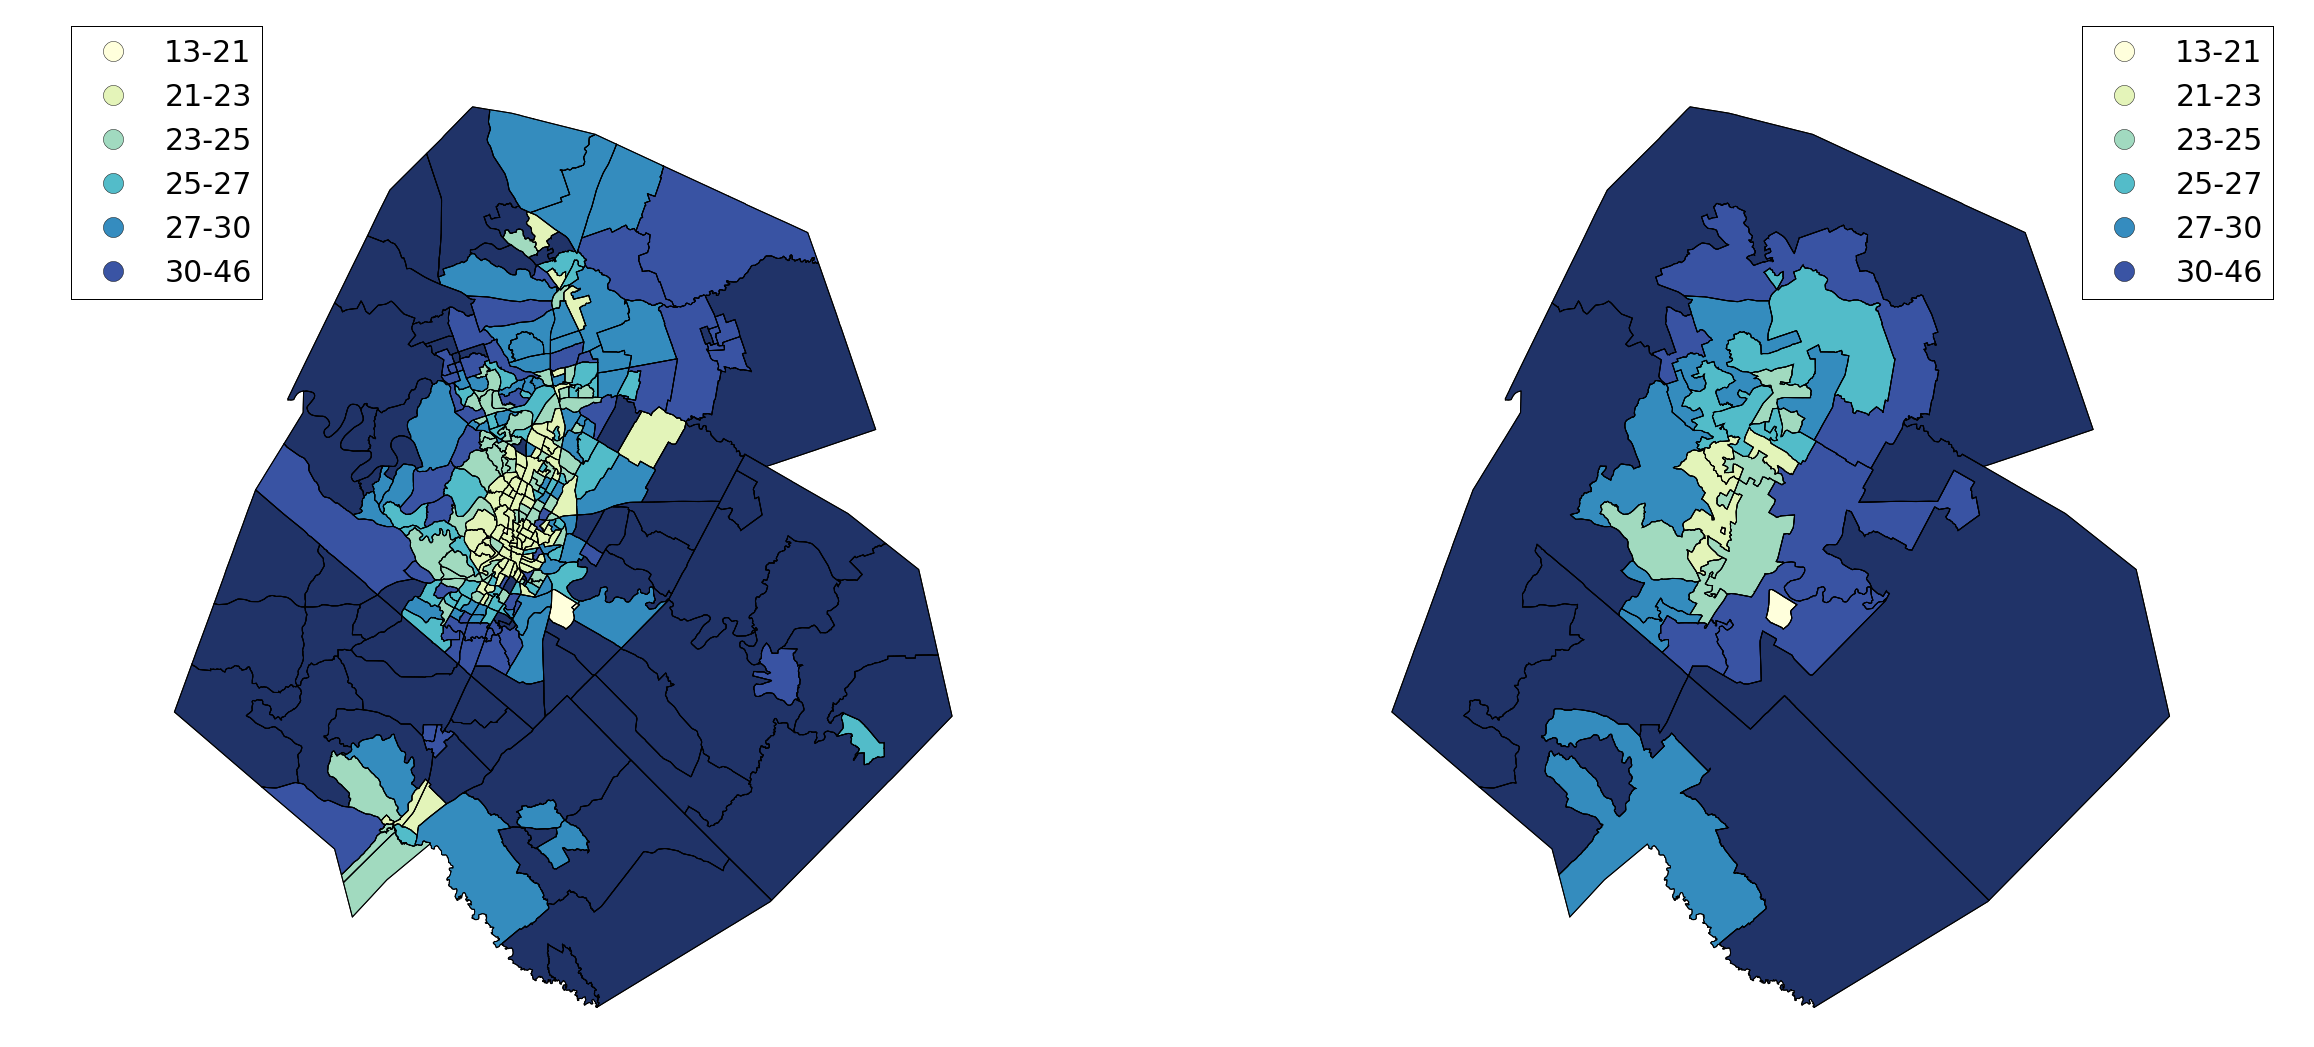

In [15]:
fig, axes = two_plot_setup()

# setup the choropleth breaks and labels
breaks = [13,21,23,25,27,30,46]
labels = [str(breaks[i])+'-'+str(breaks[i+1]) for i in range(len(breaks)-1)]
alpha = 0.9
colormap = 'YlGnBu'

# choropleth map of the input data (tracts)
shp_map['ests_interval'] = pd.cut(ests_area, breaks, right=False, labels=labels)
p = shp_map.plot('ests_interval', categorical=True, alpha=alpha, colormap=colormap, axes=axes[0])
add_legend(labels, alpha, colormap, shp_map.ests_interval, p, 'upper left')

# choropleth map of the output data (regions)
region_map['ests_interval'] = pd.cut(ests_region, breaks, right=False, labels=labels)
p1 = region_map.plot('ests_interval', categorical=True, alpha=alpha, colormap=colormap, axes=axes[1])
add_legend(labels, alpha, colormap, region_map.ests_interval, p1, 'upper right')

print "CV counts for census tracts\n", shp_map.ests_interval.value_counts(sort=False)
print "CV counts for regions\n", region_map.ests_interval.value_counts(sort=False)

Now we plot the uncertainty on the tract data and the region data.  We set the uncertainty threshold to the relatively restrictive 0.05 level for pedagogic purposes.  For the original data, none of the tracts meet this threshold (i.e. none are the lightest color).  However, all the regions in the map on the right do meet the threshold. The algorithm has therefore improved the data quality.

In [16]:
'''
When plotting a choropleth map, geopandas searches for the number of 
unique categories and bases the plot on those. For the example below, 
we need both plots to have the same set of categories. This function 
provides a less than ideal workaround by adding a fake geometry for 
each possible category. The fake geometries are not plotted.
'''
def add_all_categories(df, labels):
    df_temp = df.copy(deep=True)
    for idx, label in enumerate(labels):
        df_temp.loc[idx+1000] = 'empty'
        df_temp.loc[idx+1000,'geometry'] = shapely.geometry.Polygon()
        df_temp.loc[idx+1000,'cvs_interval'] = label
    df_temp = df_temp[df_temp.rids >= 0]  # clear out the excluded areas
    return df_temp

CV counts for census tracts
0-0.05        0
0.05-0.1     39
0.1-0.15    154
0.15-0.2    104
0.2-0.25     38
0.25-0.3      8
0.3-inf       4
dtype: int64
CV counts for regions
0-0.05      29
0.05-0.1     0
0.1-0.15     0
0.15-0.2     0
0.2-0.25     0
0.25-0.3     0
0.3-inf      0
dtype: int64


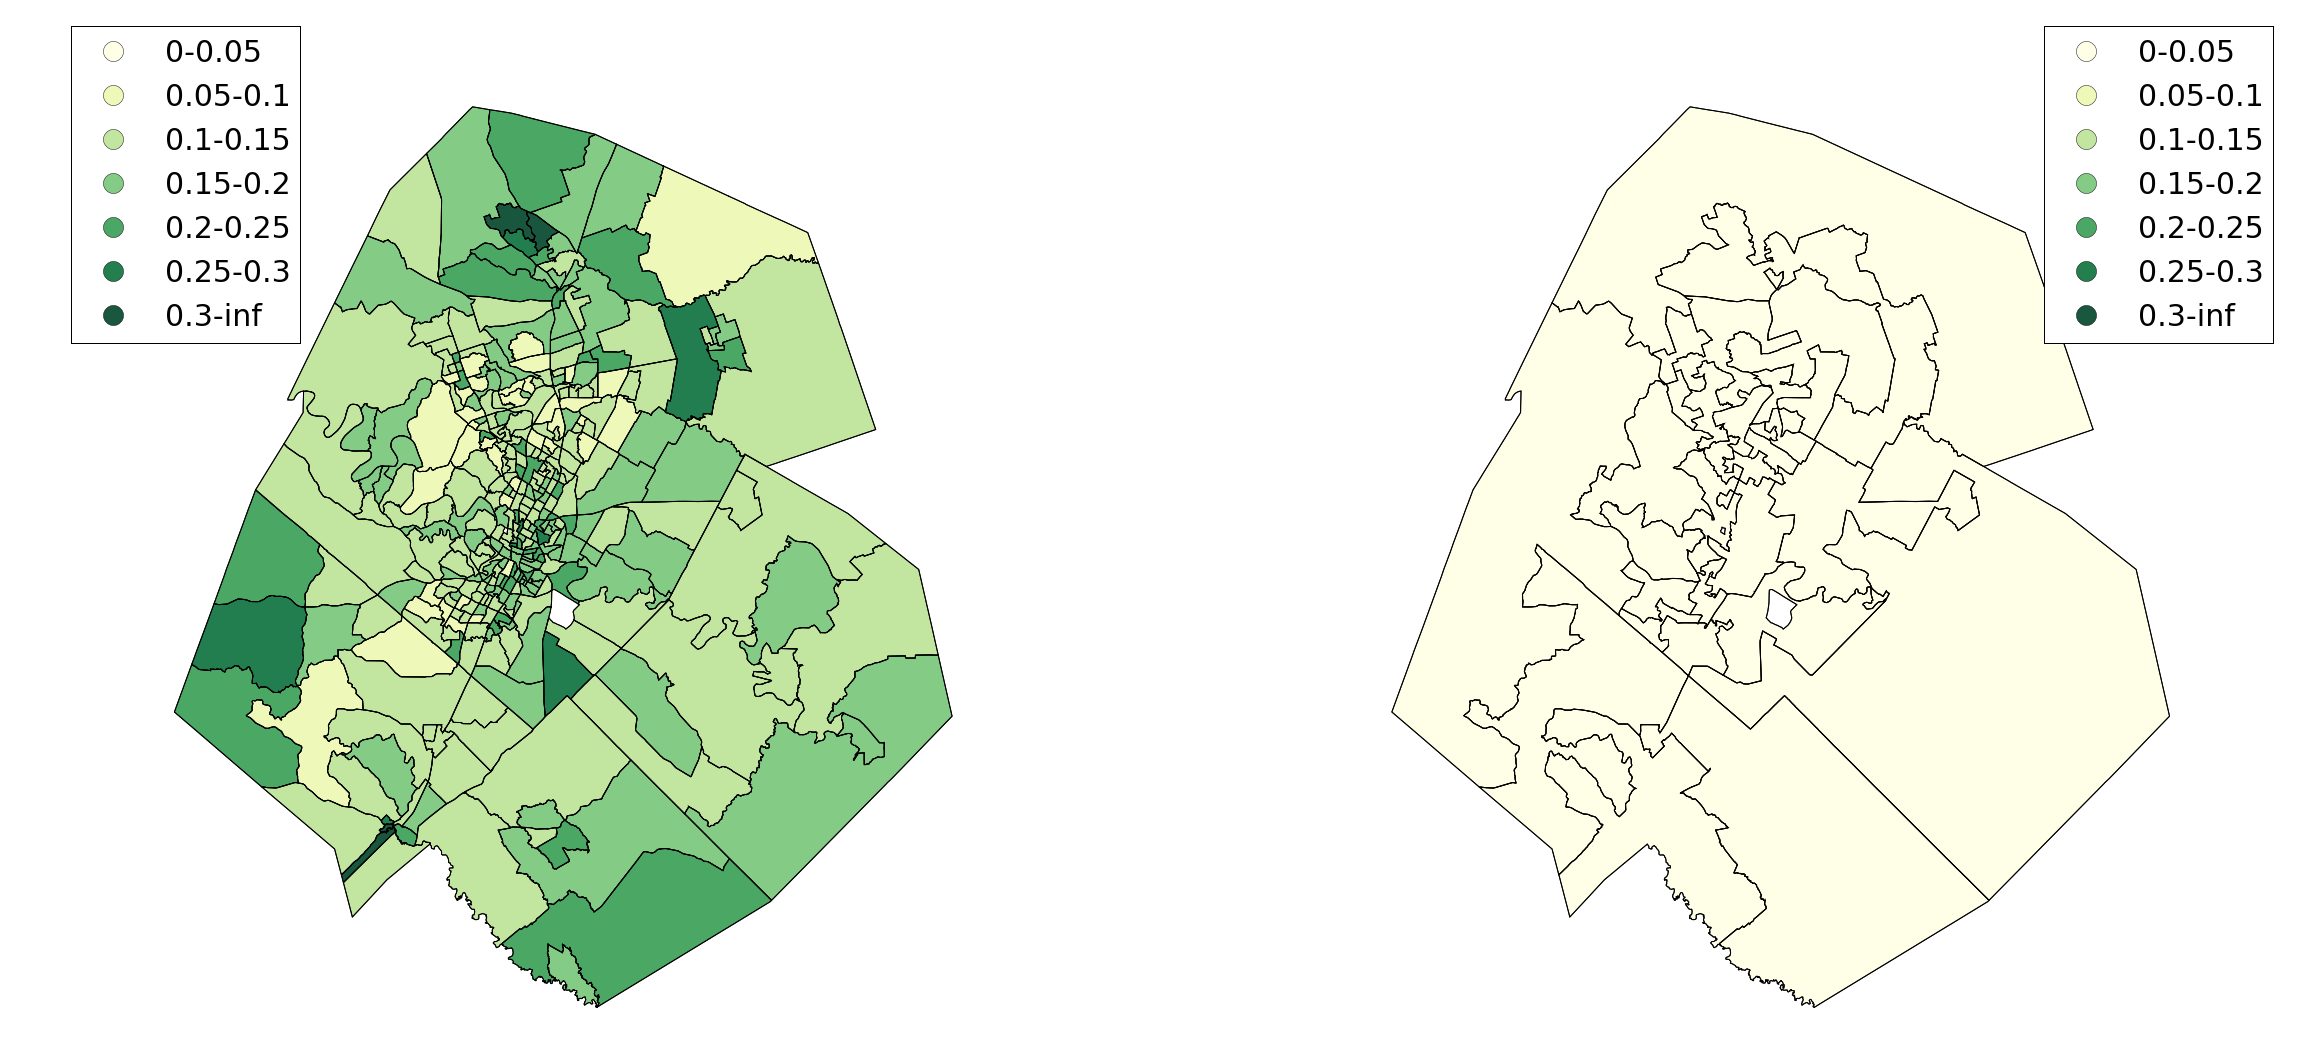

In [17]:
fig, axes = two_plot_setup()

# setup the choropleth breaks and labels
breaks = [0,0.05,0.1,0.15,0.2,0.25,0.30,np.Inf]
labels = [str(breaks[i])+'-'+str(breaks[i+1]) for i in range(len(breaks)-1)]
alpha = 0.9
colormap = 'YlGn'

# choropleth map of the input data (tracts)
shp_map['cvs_interval'] = pd.cut(cvs_area, breaks, right=False, labels=labels)
shp_map_temp = add_all_categories(shp_map, labels)
p = shp_map_temp.plot('cvs_interval', categorical=True, alpha=alpha, colormap=colormap, axes=axes[0])
add_legend(labels, alpha, colormap, shp_map_temp.cvs_interval, p, 'upper left')

# choropleth map of the output data (regions)
region_map['cvs_interval'] = pd.cut(cvs_region, breaks, right=False, labels=labels)
region_map_temp = add_all_categories(region_map, labels)
p1 = region_map_temp.plot('cvs_interval', categorical=True, alpha=alpha, colormap=colormap, axes=axes[1])
add_legend(labels, alpha, colormap, region_map_temp.cvs_interval, p1, 'upper right')

print "CV counts for census tracts\n", shp_map.cvs_interval.value_counts(sort=False)
print "CV counts for regions\n", region_map.cvs_interval.value_counts(sort=False)